## Look at some embeddings of various consecutive positions from several games, is there a pattern?

1. Extraxt positions from test games
2. Embed positions using various embedding models
3. Visualise PCA components or embeddings

## 1. Extract positions from test games

In [1]:
import chess
from chess import pgn

In [2]:
title = []
fen = []
pgn = open("../data/raw/test.pgn")
i = 0

while True:
    game = chess.pgn.read_game(pgn)

    if game is None:
        break
    else:
        board = game.board()
        positions = []
        i += 1
        title.append(f'game {i}')
        
        for move in game.mainline_moves():
            board.push(move)
            positions.append(board.fen())
        
        fen.append(positions)

print(f"{len(title)} games parsed")
print(f"number of moves {[len(arr) for arr in fen]}")
print(f"first position {fen[0][0]}")

190 games parsed
number of moves [25, 35, 21, 94, 46, 63, 38, 55, 73, 90, 74, 93, 49, 69, 117, 16, 74, 127, 59, 37, 71, 37, 33, 93, 63, 85, 42, 97, 55, 59, 81, 98, 91, 48, 86, 49, 14, 77, 77, 48, 19, 171, 106, 54, 82, 54, 135, 40, 63, 51, 62, 108, 42, 48, 43, 42, 23, 43, 56, 100, 34, 46, 63, 31, 91, 99, 82, 44, 46, 29, 74, 68, 101, 56, 29, 55, 62, 28, 75, 23, 66, 16, 38, 49, 104, 87, 49, 81, 84, 128, 47, 55, 69, 92, 64, 23, 7, 21, 21, 55, 71, 65, 49, 120, 81, 68, 69, 64, 139, 85, 60, 65, 60, 117, 45, 73, 57, 56, 51, 121, 9, 52, 62, 77, 75, 87, 63, 61, 77, 77, 77, 45, 35, 43, 107, 55, 38, 26, 41, 65, 39, 20, 61, 159, 57, 62, 41, 72, 58, 38, 62, 69, 55, 33, 48, 49, 142, 141, 45, 70, 123, 78, 46, 139, 54, 148, 51, 24, 65, 76, 59, 62, 123, 72, 23, 31, 41, 63, 24, 45, 67, 46, 51, 49, 62, 38, 78, 25, 28, 32]
first position rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1


## 2. Embed positions

In [3]:
import numpy as np
import tensorflow as tf
from chesspos.binary_index import board_to_bitboard

In [4]:
encoder_path = "deep64/model_encoder.h5"

In [5]:
encoder = tf.keras.models.load_model(encoder_path)

In [6]:
embeddings = []

for game in fen:
    pos = []
    
    for position in game:
        board = chess.Board(position)
        bb = board_to_bitboard(board)
        pos.append(bb)
    pos = np.asarray(pos)
    
    embeddings.append( encoder(pos) )

print(f"embedding dimension {embeddings[0][0].shape}")

embedding dimension (64,)


## 3. Embedding visualisation

In [7]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
%matplotlib inline

In [8]:
# prepare data
data = np.empty((0,64))
for embs in embeddings:
    data = np.concatenate((data, embs))
print(f"data.shape={data.shape}")

# fir standard scaler
#scaler = StandardScaler()
#scaler.fit(data)

# fit pca
pca_transform = PCA(n_components=2)
pca_transform.fit(data)

# fit umap
umap_transform = umap.UMAP()
umap_transform.fit(data)

# transform embeddings
reduced_embeddings = []

for emb in embeddings:
    #scaled = scaler.transform(emb)
    #reduced_embeddings.append( pca_transform.transform(emb) )
    reduced_embeddings.append( umap_transform.transform(emb) )


print(f"reduced embeddings for game 0: {reduced_embeddings[0].shape}")

data.shape=(12025, 64)
reduced embeddings for game 0: (25, 2)


In [10]:
# Source: https://nbviewer.jupyter.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
'''
Defines a function colorline that draws a (multi-)colored 2D line with coordinates x and y.
The color is taken from optional data in z, and creates a LineCollection.

z can be:
- empty, in which case a default coloring will be used based on the position along the input arrays
- a single number, for a uniform color [this can also be accomplished with the usual plt.plot]
- an array of the length of at least the same length as x, to color according to this data
- an array of a smaller length, in which case the colors are repeated along the curve

The function colorline returns the LineCollection created, which can be modified afterwards.

See also: plt.streamplot
'''

def make_segments(x, y):
    '''
    Create list of line segments from x and y coordinates, in the correct format for LineCollection:
    an array of the form   numlines x (points per line) x 2 (x and y) array
    '''
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

def colorline(ax, x, y, z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0), linewidth=3, alpha=1.0):
    '''
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    '''    
    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])
    z = np.asarray(z)
    segments = make_segments(x, y)
    lc = LineCollection(segments, array=z, cmap=cmap, norm=norm, linewidth=linewidth, alpha=alpha)
    ax = plt.gca()
    ax.add_collection(lc)
    return ax, lc

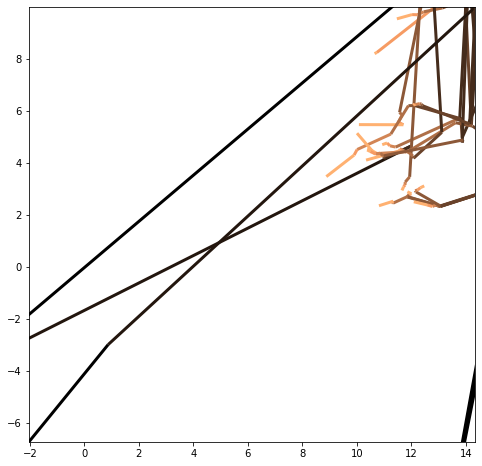

In [18]:
games = 15
firstxmoves = 10
fig, ax = plt.subplots(figsize=(8, 8))
for embs in reduced_embeddings[:games]:
    #print(embs[:firstxmoves].shape)
    x, y = zip(*embs[:firstxmoves])
    x, y = np.asarray(x), np.asarray(y)
    plt.xlim(x.min(), x.max())
    plt.ylim(y.min(), y.max())
    ax, lc = colorline(ax, x, y)

## Conclusion: approach only works for the first couple of moves, mybe more training samples are required?